<a href="https://colab.research.google.com/github/Ethan-Swanepoel/APDS7311_FINAL_POE/blob/main/PDAN8412_POE_Part_1_RNN_AuthorClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **# Part 1: Author Classification using LSTM and PySpark**



## Dataset Justification
The dataset (`books.csv`), containing book descriptions and authors, is suitable for an LSTM model because it contains sequential text (`bookDesc`) that can capture writing style.  
- **Strengths:** Sequential nature of text, enough records (>10,000).  
- **Challenges:** Many unique authors, strong class imbalance (some authors only appear once).  




In [14]:
# ## Setup Spark & Python Environment
# This cell installs necessary libraries and initializes a SparkSession for data processing.

!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install pyspark
!pip install tensorflow keras scikit-learn matplotlib seaborn

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BooksEDA") \
    .getOrCreate()

# Test Spark
spark.range(5).show()

+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
+---+



In [15]:
# ✅ Upload Dataset
from google.colab import files
uploaded = files.upload()

# Load into Spark
df_spark = spark.read.csv("books.csv", header=True, inferSchema=True)
df_spark.printSchema()
df_spark.show(5)


Saving books.csv to books.csv
root
 |-- url: string (nullable = true)
 |-- bookTitle: string (nullable = true)
 |-- bookImage: string (nullable = true)
 |-- bookAuthors: string (nullable = true)
 |-- bookDesc: string (nullable = true)
 |-- bookRating: string (nullable = true)
 |-- ratingCount: string (nullable = true)
 |-- reviewCount: string (nullable = true)
 |-- bookPages: string (nullable = true)
 |-- bookGenres: string (nullable = true)
 |-- bookISBN: string (nullable = true)
 |-- recommendations: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+----------------+--------------------+
|                 url|           bookTitle|           bookImage|         bookAuthors|            bookDesc|          bookRating|         ratingCount|       reviewCount|           bookPages|          bookGenres|        b

In [16]:

# ✅ Exploratory Data Analysis (Spark)
print("Dataset size:", df_spark.count())
print("Columns:", df_spark.columns)

# Select only author + description for classification
df_text = df_spark.select("bookAuthors", "bookDesc").na.drop()

# Count top authors
df_text.groupBy("bookAuthors").count().orderBy("count", ascending=False).show(10)


Dataset size: 10839
Columns: ['url', 'bookTitle', 'bookImage', 'bookAuthors', 'bookDesc', 'bookRating', 'ratingCount', 'reviewCount', 'bookPages', 'bookGenres', 'bookISBN', 'recommendations']
+-------------------+-----+
|        bookAuthors|count|
+-------------------+-----+
|       Stephen King|   48|
|    Terry Pratchett|   37|
|      Sarah J. Maas|   33|
|          Meg Cabot|   30|
|   Sherrilyn Kenyon|   28|
|  Brandon Sanderson|   27|
|Laurell K. Hamilton|   27|
|        Erin Hunter|   26|
|         L.J. Smith|   25|
|       Rick Riordan|   25|
+-------------------+-----+
only showing top 10 rows



In [17]:

# ✅ Convert to Pandas for ML
df_pd = df_text.toPandas()
print(df_pd.head())


                  bookAuthors  \
0             Suzanne Collins   
1  J.K. Rowling,Mary GrandPré   
2                  Harper Lee   
3   Jane Austen,Anna Quindlen   
4             Stephenie Meyer   

                                            bookDesc  
0  Could you survive on your own in the wild, wit...  
1  There is a door at the end of a silent corrido...  
2  "The unforgettable novel of a childhood in a s...  
3  "Alternate cover edition of ISBN 9780679783268...  
4  About three things I was absolutely positive.F...  


In [18]:

# ✅ Encode Authors
from sklearn.preprocessing import LabelEncoder
import numpy as np

encoder = LabelEncoder()
df_pd["author_encoded"] = encoder.fit_transform(df_pd["bookAuthors"])


In [19]:
# ✅ Tokenize Text
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_pd["bookDesc"])

sequences = tokenizer.texts_to_sequences(df_pd["bookDesc"])
padded = pad_sequences(sequences, maxlen=300, padding="post", truncating="post")

X = padded
y = df_pd["author_encoded"].values

In [20]:

# ✅ Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [21]:

# ✅ Build LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = 10000
embedding_dim = 64
max_length = 300

model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(len(np.unique(y)), activation="softmax")
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [22]:

# ✅ Train Model
history = model.fit(
    X_train, y_train,
    epochs=3,
    validation_data=(X_test, y_test),
    batch_size=64
)


Epoch 1/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 126s 932ms/step - accuracy: 0.0019 - loss: 8.5854 - val_accuracy: 0.0039 - val_loss: 8.5200
Epoch 2/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 122s 946ms/step - accuracy: 0.0045 - loss: 8.2339 - val_accuracy: 0.0039 - val_loss: 8.6976
Epoch 3/3
129/129 ━━━━━━━━━━━━━━━━━━━━ 141s 937ms/step - accuracy: 0.0049 - loss: 8.1612 - val_accuracy: 0.0039 - val_loss: 8.8679


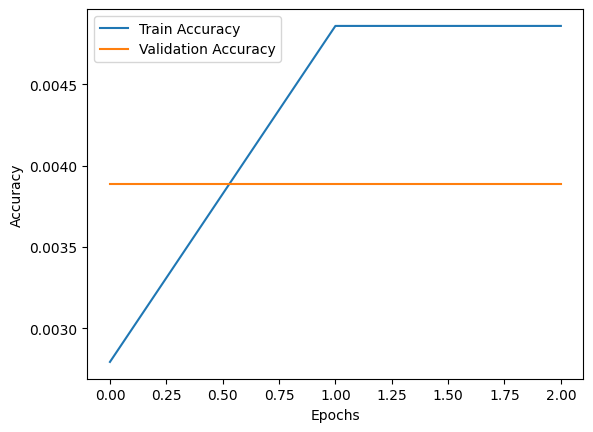

65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        precision    recall  f1-score   support

                                                                                                                                                                                                                                                                                                                                                                             

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [24]:
# ## Evaluate the Model's Performance
# This cell evaluates the trained model using accuracy plots and a classification report.

# ✅ Evaluate Model
import matplotlib.pyplot as plt
import numpy as np # Import numpy here if not already imported

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Predict and evaluate
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
# Get the unique classes in y_test and use them to select the correct target names
target_class_indices = np.unique(y_test)
target_names = encoder.classes_[target_class_indices]

print(classification_report(y_test, y_pred, target_names=target_names, labels=np.unique(y_test)))